In [14]:
import cv2
import numpy as np
import os
from sklearn import tree
from sklearn import preprocessing
import graphviz
#I Have problems with packages try running without this command 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import glob
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pathlib
from torchvision.transforms import ToTensor

In [15]:
#checking for device
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")


tensor([1.], device='mps:0')


In [16]:
def extract_color_features(image, target_size):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the number of bins for each channel in the histogram
    hue_bins = 8
    saturation_bins = 8
    value_bins = 8

    # Calculate the color histogram for each channel
    hue_hist = cv2.calcHist([hsv_image], [0], None, [hue_bins], [0, 180])
    saturation_hist = cv2.calcHist([hsv_image], [1], None, [saturation_bins], [0, 256])
    value_hist = cv2.calcHist([hsv_image], [2], None, [value_bins], [0, 256])

    # Normalize the histograms
    cv2.normalize(hue_hist, hue_hist, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(saturation_hist, saturation_hist, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(value_hist, value_hist, 0, 1, cv2.NORM_MINMAX)

    # Concatenate the histograms into a single feature vector
    color_features = np.concatenate((hue_hist.flatten(), saturation_hist.flatten(), value_hist.flatten()))

    # Resize the color features to the target size
    if len(color_features) < target_size:
        color_features = np.pad(color_features, (0, target_size - len(color_features)), mode='constant')
    elif len(color_features) > target_size:
        color_features = color_features[:target_size]

    #print("Color features:", color_features.shape)

    return color_features

In [17]:
def extract_shape_features(image, target_size):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding to obtain a binary image
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store shape features
    shape_features = []

    # Iterate over the contours
    for contour in contours:
        # Calculate contour-based features
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        _, _, width, height = cv2.boundingRect(contour)
        aspect_ratio = width / float(height) if height != 0 else 0
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0

        # Append the shape features to the list
        shape_features.extend([area, perimeter, aspect_ratio, circularity])

    # Convert the shape features list to a numpy array
    shape_features = np.array(shape_features)

    # Resize the shape features to the target size
    if len(shape_features) < target_size:
        shape_features = np.pad(shape_features, (0, target_size - len(shape_features)), mode='constant')
    elif len(shape_features) > target_size:
        shape_features = shape_features[:target_size]

    #print("Shape features:", shape_features.shape)
    return shape_features

In [18]:
def extract_texture_features(image, target_size):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the Local Binary Pattern (LBP) for the grayscale image
    radius = 1
    n_points = 8 * radius
    lbp_image = local_binary_pattern(gray_image, n_points, radius, method='uniform')

    # Calculate the histogram of the LBP image
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    # Flatten and return the histogram as the texture feature vector
    texture_features = hist.flatten()

    # Resize the texture features to the target size
    if len(texture_features) < target_size:
        texture_features = np.pad(texture_features, (0, target_size - len(texture_features)), mode='constant')
    elif len(texture_features) > target_size:
        texture_features = texture_features[:target_size]

    #print("Texture features:", texture_features.shape)

    return texture_features

In [19]:
def combine_features(image):
    # Load and preprocess the image
    # Assuming image is already loaded or you can use OpenCV to load it
    preprocessed_image = image
    #print(preprocessed_image)

    # Extract features using different methods
    color_features = extract_color_features(preprocessed_image,24)
    shape_features = extract_shape_features(preprocessed_image,20)
    texture_features = extract_texture_features(preprocessed_image,10)

    # Combine the features into a single vector
    #print(color_features.shape, shape_features.shape, texture_features.shape)
    combined_features = np.concatenate((color_features, shape_features, texture_features),axis=None)

    return combined_features

In [83]:

#folder_path = "/Users/hadi/Desktop/Concordia/Comp 6721/AIproject/fruits/training/Kiwi_Training"

def generate_features(image):
    #image = cv2.imread(image_path)
    #new_size = (32, 32)
    #image = cv2.resize(image, new_size)
    combined_features = combine_features(image)
    return combined_features

def check_label(element):
    if element == 'Banana_Training' or element == "Banana_Test":
        return 1
    elif element == 'Kiwi_Training' or element == "Kiwi_Test":
        return 2
    elif element == 'Mango_Training' or element == "Mango_Test":
        return 3
    elif element == 'Orange_Training' or element == "Orange_Test":
        return 4
    elif element == 'Plum_Training' or element == "Plum_Test":
        return 5
    elif element == 'Apple_Training' or element == "Apple_Test":
        return 6
    else:
        return 0  # Return 0 if the element is not found in the list

def loadImages(folder_path,class_):
    #print(folder_path)
    folder_path = folder_path
    file_list = os.listdir(folder_path)
    class_features = np.empty((0,55))
    for file_name in file_list:
         if file_name.endswith(".jpg") or file_name.endswith(".png"):
             image_path = os.path.join(folder_path, file_name)
             # Perform your image processing tasks here
             image = cv2.imread(image_path)
             new_size = (32, 32)
             image = cv2.resize(image, new_size)
             combined_features = combine_features(image)
             #print(check_label(class_))
             combined_features = np.append(combined_features, check_label(class_))
             combined_features = np.expand_dims(combined_features, axis=0)
             class_features = np.append(class_features, combined_features,axis=0)
    #print(class_features[0])
    return class_features
        

            

#Print the shape of the combined feature vector
#loadImages(folder_path,"Kiwi_Training")

In [84]:
train_path = "/Users/hadi/Desktop/Concordia/Comp 6721/AIproject/fruits/training"
test_path = "/Users/hadi/Desktop/Concordia/Comp 6721/AIproject/fruits/testing"

root_training=pathlib.Path(train_path)
root_testing=pathlib.Path(test_path)


def generate_feature_vector(root,path):
    classes = []
    features = np.empty((0,55))
    labels = []
    for class_dir in root.iterdir():
        class_ = class_dir.name.split('/')[-1]
        print(class_)
        path_ = path +"/"
        if(class_!=".DS_Store"):
            print(class_)
            path_ = path+"/"+class_
            temp = loadImages(path_,class_)
            path_ = ""
            classes.append(class_)
            features = np.append(features, temp,axis=0)
                
    return features 
#classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
#print(classes) #['Banana_Training', 'Kiwi_Training', 'Mango_Training', 'Orange_Training', 'Plum_Training', 'Apple_Training']


In [85]:
#calculate size of training and testing images 

f = generate_feature_vector(root_training,train_path) #total training features 
t = generate_feature_vector(root_testing,test_path) #total testing features
print(f.shape)
print(t.shape)
#train_count = len(glob.glob(train_path+"/**/*.png"))
#test_count = len(glob.glob(test_path+"/**/*.png"))

#print(train_count,test_count)


Banana_Training
Banana_Training
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


              precision    recall  f1-score   support

         1.0       0.73      0.68      0.70       605
         2.0       0.79      0.88      0.84       858
         3.0       0.74      0.83      0.78       831
         4.0       0.93      0.95      0.94       603
         5.0       0.95      0.95      0.95       460
         6.0       0.88      0.76      0.82      1226

    accuracy                           0.83      4583
   macro avg       0.84      0.84      0.84      4583
weighted avg       0.83      0.83      0.83      4583

Confusion Matrix:
 [[411  12 162   5   2  13]
 [ 21 759  16   1   4  57]
 [ 67  24 686  18   2  34]
 [  5   2   9 574   2  11]
 [  1  13   0   0 437   9]
 [ 60 146  58  17  13 932]]


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

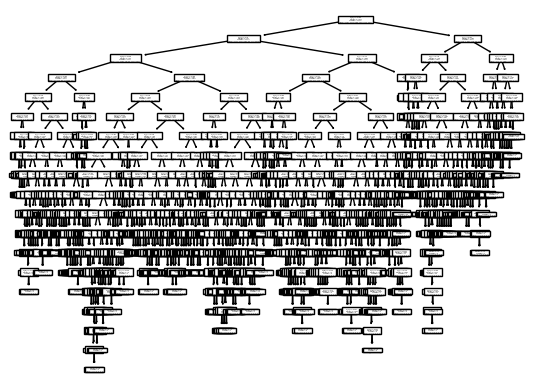

In [90]:
# #Model Training and saving best model
import sys

xtrain = f[:,:-1]
ytrain = f[:,-1]

xtest = t[:,:-1]
ytest = t[:,-1]

# print("Features for training:" ,xtrain)
# print("Labels for training", ytrain)
# print("Features for testing:", xtest)
# with np.printoptions(threshold=sys.maxsize):
#     print("Labels for training", ytrain)
#     print("Labels for testing", ytest)


dtc = tree.DecisionTreeClassifier(criterion="entropy")
dtc.fit(xtrain, ytrain)

y_pred = dtc.predict(xtest)
from sklearn.metrics import classification_report 
print(classification_report(ytest, y_pred))
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred))
tree.plot_tree(dtc)
elements = ["color"] * 24 + ["shape"] * 20 + ["texture"] * 10
dot_data = tree.export_graphviz(dtc, out_file=None, feature_names=elements, class_names=['Banana', 'Apple',"Orange","Plum","Mango","Kiwi"],filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render("mytree")


In [ ]:
dot -V